In [ ]:
!pip install emoji
!pip install googletrans-temp
!pip install spellchecker
!pip install pyspellchecker
!pip install langdetect
!pip install nltk
!pip install textblob

In [ ]:
import pandas as pd
import numpy as np
import csv

Loading the Data


In [ ]:
non_Sarcasm_Data = pd.read_csv('/data/Non_Sarcasm_Data.csv')
sarcasm_Data = pd.read_csv('/data/Sarcasm_Data.csv')

In [ ]:
print(non_Sarcasm_Data.shape)
print(sarcasm_Data.shape)

(73683, 6)
(25115, 6)


We have 25,115 author intended sarcastic Tweets and 73682 non sarcastic tweets.
Lets combine these two in an almost equal ratios

In [ ]:
non_Sarcasm_Data = non_Sarcasm_Data[~non_Sarcasm_Data.text.str.contains('sarcasm')].sample(n=24783)
print("Sarcasm Tweet Data: " + str(len(sarcasm_Data)))
print("Normal Tweet Data: " + str(len(non_Sarcasm_Data)))

Sarcasm Tweet Data: 25115
Normal Tweet Data: 24783


Lets set sarcasm labels to the data

In [ ]:
non_Sarcasm_Data.insert(2,'Sarcasm',0)
sarcasm_Data.insert(2,'Sarcasm',1)

In [ ]:
twitter_data = sarcasm_Data.append(non_Sarcasm_Data)
twitter_data = twitter_data.sample(frac=1).reset_index(drop=True)

Now that we have a single dataframe with both sarcastic and non sarcastic tweets.

In [ ]:
twitter_data['Sarcasm'].value_counts()

1    25115
0    24783
Name: Sarcasm, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

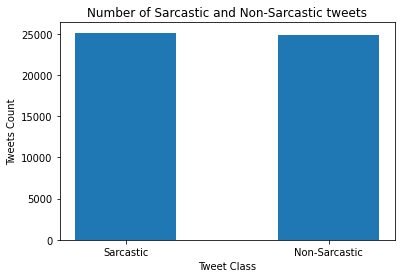

In [ ]:
labels=["Sarcastic", "Non-Sarcastic"]
plt.bar(labels, twitter_data['Sarcasm'].value_counts(), width = 0.5)
plt.xlabel("Tweet Class") 
plt.ylabel("Tweets Count") 
plt.title("Number of Sarcastic and Non-Sarcastic tweets") 
plt.show() 

Lets make a copy of the text column

In [ ]:
twitter_data['Text'] = twitter_data['text']

Before we get into cleaning the data, lets have a look at few details the data has to offer us.

In [ ]:
from ast import literal_eval  #Library to handle hashtags key:value format
def handle_hastags(text):            #Converting Hashtags Key:Value pair to value only string
    Hashtags = ""
    newtext = ""
    for j in range(len(literal_eval(text))):
        Hashtags = Hashtags + ' ' + literal_eval(text)[j].get('text')
        Hashtags = Hashtags.lstrip()
        if not 'sarcasm' in Hashtags.lower():
            if not 'meme' in Hashtags.lower():
                newtext = newtext + " " + Hashtags
    return newtext.lstrip()

In [ ]:
twitter_data['Hashtags'] = twitter_data['Hashtags'].apply(handle_hastags)

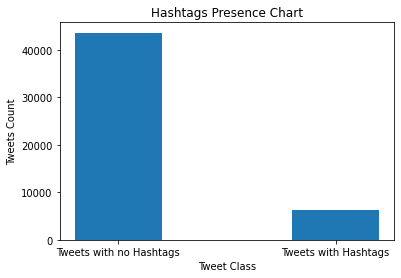

In [ ]:
labels=["Tweets with no Hashtags", "Tweets with Hashtags"]
plt.bar(labels, twitter_data['Hashtags'].apply(lambda x: 0 if x == "" else 1).value_counts(), width = 0.4)
plt.xlabel("Tweet Class") 
plt.ylabel("Tweets Count") 
plt.title("Hashtags Presence Chart")
plt.show() 

In [ ]:
import emoji   #library to handle emoji's
def extract_emojis(text):           #Extract emojis from text
  return ''.join(emo for emo in text if emo in emoji.UNICODE_EMOJI)

#Extract emoji's from dataset into a new column 
twitter_data['Emoticons'] = twitter_data['text'].apply(extract_emojis)

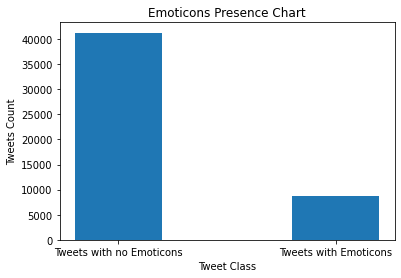

In [ ]:
labels=["Tweets with no Emoticons", "Tweets with Emoticons"]
plt.bar(labels, twitter_data['Emoticons'].apply(lambda x: 0 if x == "" else 1).value_counts(), width = 0.4)
plt.xlabel("Tweet Class") 
plt.ylabel("Tweets Count") 
plt.title("Emoticons Presence Chart")
plt.show() 

In [ ]:
twitter_data.text.head(10)

0    Online Bill Pay ~ It's fast, easy, convenient ...
1                               Why React is a library
2                                    @bstlust aw tyyyy
3    @TexaLonestar @pastorlocke Sorry for his loss,...
4    @SilkCutBlue @paulhowey @eugeneoregan @LBC Thi...
5    @thepennyhoarder Step one: put it all in the f...
6    @KimParkLee14 @LucianaBarrell @rienepi @snake1...
7    @J2l2d @7amzamz Follow ⇚⇛️ back Follow ⇚⇛️ bac...
8    All-day. Everyday! Who can relate? #ArchiesOnl...
9              @soulphoodie Smash! Mmmmmm looks juicy!
Name: text, dtype: object

Looking at the tweets above, things to work with would be
1) Emoticons
2) hashtags
3) user tags

In [ ]:
import re
def remove_emoji(string):            #Removing Emoji's from text
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
twitter_data['Text'] = twitter_data['Text'].apply(remove_emoji)

In [ ]:
def HandleSymbolsOnly(text):        #Removes any symbols in the text
    newtext=''
    for i in range(len(text.split())):
        word = re.sub(r'\W','',text.split()[i])
        newtext = newtext + " " + word
    newtext.lstrip()
    return newtext

def clean_tweet(text):             #Removes mention tags, remove _ in words, hashtags, any symbols, only numeric words
    text = re.sub(r'@_*[A-Za-z0-9]+','',text) #Removing tags/@mentions
    text = re.sub(r'_','',text) #Removing words with _
    text = re.sub(r'#(\S+)','',text) #Removing hastags with words
    text = HandleSymbolsOnly(text)
    text = text.strip()
    return text

In [ ]:
#Clean tweets by symbols, mention-tags, hashtags
twitter_data['Clean_Text'] = twitter_data['Text'].apply(clean_tweet)

In [ ]:
twitter_data['Clean_Text'].head(10)

0    Online Bill Pay  Its fast easy convenient and ...
1                               Why React is a library
2                                             aw tyyyy
3    Sorry for his loss but because you disagree wi...
4    This is true to be fair But its still so so so...
5                   Step one put it all in the freezer
6                           ii Laid on my bed like a c
7    Follow  back Follow  back Follow  back Follow ...
8                       Allday Everyday Who can relate
9                             Smash Mmmmmm looks juicy
Name: Clean_Text, dtype: object

In [ ]:
twitter_data = twitter_data[twitter_data['Clean_Text'] != ""]

In [ ]:
from wordcloud import WordCloud, STOPWORDS
# plot the WordCloud image 
def plotWordCloud(column):
    comment_words = '' 
    stopwords = set(STOPWORDS)
    for val in column:
        val = str(val)
        tokens = val.split() 
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
            comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 6,
                collocations=False).generate(comment_words) 
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

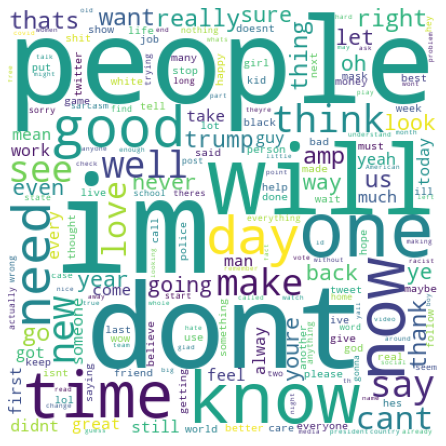

In [ ]:
plotWordCloud(twitter_data['Clean_Text'])

In [ ]:
from spellchecker import SpellChecker    #Library to perform spell checker on text
def spell_check(text):          #Correct spelling's in the text
    spell  = SpellChecker()
    correct_word = []
    mispelled_words = text.split()
    for word in mispelled_words:
        correct_word.append(spell.correction(word))
    return ' '.join(correct_word)


In [ ]:
twitter_data['Clean_Text'] = twitter_data['Clean_Text'].apply(spell_check)

In [ ]:
twitter_data['Sarcasm'].value_counts()

1    25058
0    24732
Name: Sarcasm, dtype: int64

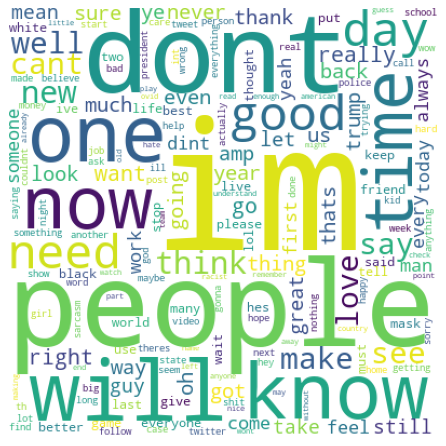

In [ ]:
plotWordCloud(twitter_data['Clean_Text'])

In [ ]:
from nltk.corpus import stopwords    #importing predefined stopwords by nltk
import nltk
nltk.download('stopwords')
def removal_of_stopwords(text):    #Removing stop words from the text
    nltkstopwords = set(stopwords.words('english'))
    nostopword = []
    for word in text.split():
        if word.lower() not in nltkstopwords:
            nostopword.append(word)
    return ' '.join(nostopword)

twitter_data['Clean_Text_Without_Stopwords'] = twitter_data['Clean_Text'].apply(removal_of_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from textblob import TextBlob, Word     #NLP library for Lemmatization
def lemmatize_with_postag(sentence):              #Lemmatize words in the text
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

twitter_data['Lemmatized_Clean_Text_Without_Stopwords'] = twitter_data['Clean_Text_Without_Stopwords'].apply(lemmatize_with_postag)

In [ ]:
twitter_data = twitter_data[twitter_data['Lemmatized_Clean_Text_Without_Stopwords'].apply(lambda x: len(x.split()) > 2)]

In [ ]:
twitter_data = twitter_data[~twitter_data['Lemmatized_Clean_Text_Without_Stopwords'].str.contains('Follow')]

In [ ]:
twitter_data = twitter_data.drop_duplicates(subset=['Lemmatized_Clean_Text_Without_Stopwords'], keep=False)

In [ ]:
twitter_data['Sarcasm'].value_counts()

1    21756
0    18300
Name: Sarcasm, dtype: int64

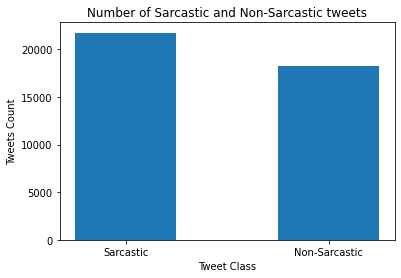

In [ ]:
labels=["Sarcastic", "Non-Sarcastic"]
plt.bar(labels, twitter_data['Sarcasm'].value_counts(), width = 0.5)
plt.xlabel("Tweet Class") 
plt.ylabel("Tweets Count") 
plt.title("Number of Sarcastic and Non-Sarcastic tweets") 
plt.show() 

In [ ]:
from nltk.tokenize import word_tokenize    #tokenize words in a text
import nltk           #NLP library for various tasks
def postag(text):       #Returns POS tagged words for each word in the text
    text = nltk.pos_tag(word_tokenize(text))
    newtxt = ""
    for i in range(len(text)):
        newtxt = newtxt + " " + ''.join(text[i])
    return newtxt

twitter_data['Postagged_Lemmatized_Text'] = twitter_data['Lemmatized_Clean_Text_Without_Stopwords'].apply(postag)

In [ ]:
twitter_data.to_csv('/data/Twitter_Data.csv')